In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from pathlib import Path
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from demo import *
from models.with_mobilenet import PoseEstimationWithMobileNet, PoseClassificationWithMobileNet
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [2]:
class CustomDataset(Dataset):
    def __init__(self, transform=None) -> None:
        super().__init__()
        self.transform = transform
        self.data_list, self.labels = self.load_data()

    def load_data(self):
        data_list, labels = [], []
        paths = Path('/home/jyji/develop/pose/lightweight-human-pose-estimation.pytorch/data/lying_pictures/').glob('*.jpg')
        for path in paths:
            data_list.append(str(path))
            labels.append(1)
        df = pd.read_csv('/home/jyji/develop/pose/lightweight-human-pose-estimation.pytorch/data/mpii/mpii_human_pose.csv')
        df = df.loc[(df['Category'] == 'miscellaneous') & (df['Activity'] == 'standing, miscellaneous')]
        file_names = [name for name in df['NAME']]
        parent = Path('/home/jyji/develop/pose/lightweight-human-pose-estimation.pytorch/data/mpii/mpii_human_pose_v1/images/')
        for file_name in file_names:
            path = parent / file_name
            data_list.append(str(path))
            labels.append(0)
        return data_list, labels
    
    def __getitem__(self, index):
        image = cv2.imread(self.data_list[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        image = self.transform(image)
        return image, self.labels[index]
    
    def __len__(self):
        return len(self.data_list)

In [3]:
pretrained = PoseEstimationWithMobileNet()
checkpoint = torch.load('./weights/checkpoint_iter_370000.pth', map_location='cpu')
load_state(pretrained, checkpoint)
net = PoseClassificationWithMobileNet(pretrained)

In [4]:
images = [path for path in Path('./data/lying_pictures/').glob('*.jpg')]
frame_provider = ImageReader(images)

In [5]:
net = net.eval()
if torch.cuda.is_available():
    net = net.cuda()

In [6]:
transform = transforms.Compose([
    transforms.Resize(size=(128, 128), antialias=True),
    transforms.RandomApply([
        # transforms.RandomResizedCrop((128, 128), scale=(0.9, 1.1), ratio=(0.9, 1.1), antialias=True), 
        transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
    ], p=0.3),
    # transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

In [7]:
dataset = CustomDataset(transform)
trainlen = int(len(dataset) * 0.8)
testlen = len(dataset) - trainlen
train_dataset, test_dataset = random_split(dataset, [trainlen, testlen])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=16)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=16)

In [8]:
optimizer = torch.optim.AdamW(net.classifier.parameters(), lr=0.001, betas=(0.5, 0.999))
loss_func = torch.nn.BCEWithLogitsLoss()

for e in range(5):
    loss_avg, acc = 0, 0
    print(f'epoch : {e+1}')
    for idx, batch in enumerate(tqdm(train_dataloader)):
        images, labels = batch
        images = images.cuda()
        labels = labels.float().cuda()

        pred = net(images)
        optimizer.zero_grad()
        loss = loss_func(pred.squeeze(), labels)
        loss.backward()
        optimizer.step()

        loss_avg += loss.cpu().detach().item()
        acc += ((torch.nn.functional.sigmoid(pred.squeeze()) > 0.5) == labels.squeeze()).float().mean().item()

    print('train loss :', loss_avg / (idx+1))
    print('train acc :', acc*100 / (idx+1) )

    loss_avg, acc = 0, 0
    for idx, batch in enumerate(tqdm(test_dataloader)):
        images, labels = batch
        images = images.cuda()
        labels = labels.float().cuda()

        pred = net(images)
        loss = loss_func(pred.squeeze(), labels)

        loss_avg += loss.cpu().detach().item()
        acc += ((torch.nn.functional.sigmoid(pred.squeeze()) > 0.5) == labels.squeeze()).float().mean().item()

    print('test loss :', loss_avg / (idx+1))
    print('test acc :', acc*100 / (idx+1))

epoch : 1


  0%|          | 0/17 [00:00<?, ?it/s]

100%|██████████| 17/17 [00:15<00:00,  1.13it/s]


train loss : 0.6699130219571731
train acc : 58.99509822621065


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


test loss : 0.636002904176712
test acc : 61.25
epoch : 2


100%|██████████| 17/17 [00:15<00:00,  1.07it/s]


train loss : 0.62464479488485
train acc : 68.16176491625168


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


test loss : 0.6481676936149597
test acc : 42.5
epoch : 3


100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


train loss : 0.5702872241244596
train acc : 74.2156866718741


100%|██████████| 5/5 [00:07<00:00,  1.52s/it]


test loss : 0.6696710169315339
test acc : 67.5
epoch : 4


100%|██████████| 17/17 [00:16<00:00,  1.06it/s]


train loss : 0.5664780788561877
train acc : 74.16666676016415


100%|██████████| 5/5 [00:07<00:00,  1.53s/it]


test loss : 0.5687492072582245
test acc : 70.0
epoch : 5


100%|██████████| 17/17 [00:14<00:00,  1.21it/s]


train loss : 0.5526883479426888
train acc : 72.64705896377563


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]

test loss : 0.5598663091659546
test acc : 75.0


In [9]:
pred

tensor([[0.8030],
        [0.8038],
        [0.7959],
        [0.7791]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [10]:
images, labels = next(iter(train_dataloader))

In [11]:
images = images.permute(0, 2, 3, 1).numpy()
labels = labels.numpy()
images.shape, labels.shape

((16, 128, 128, 3), (16,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

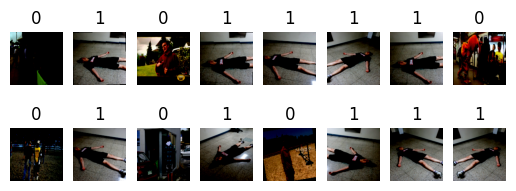

In [12]:
for i, image in enumerate(images):
    plt.subplot(4, 8, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(labels[i])

In [13]:
net = PoseEstimationWithMobileNet()
img = cv2.imread('./data/lying_pictures/0.jpg', cv2.IMREAD_COLOR)
scale = 0.06349206349206349
height_size = 256
stride = 8
scaled_img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
scaled_img = normalize(scaled_img, np.array([128, 128, 128], np.float32), np.float32(1/256))
min_dims = [height_size, max(scaled_img.shape[1], height_size)]
padded_img, pad = pad_width(scaled_img, stride, (0, 0, 0), min_dims)
padded_img = cv2.cvtColor(padded_img, cv2.COLOR_BGR2RGB)
padded_img = cv2.resize(padded_img, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
tensor_img = torch.from_numpy(padded_img).permute(2, 0, 1).unsqueeze(0).float()
# tensor_img = tensor_img.cuda()
result = net(tensor_img)

In [ ]:
a, b = result[-1].view(1, -1), result[-2].view(1, -1)
torch.cat([a, b], dim=1).shape

torch.Size([1, 14592])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


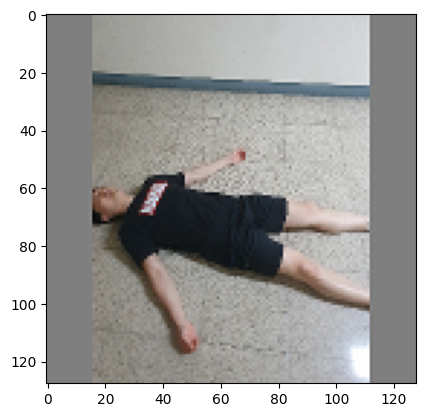

In [ ]:
scaled_img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
scaled_img = normalize(scaled_img, np.array([128, 128, 128], np.float32), np.float32(1/256))
min_dims = [height_size, max(scaled_img.shape[1], height_size)]
padded_img, pad = pad_width(scaled_img, stride, (0, 0, 0), min_dims)
padded_img = cv2.cvtColor(padded_img, cv2.COLOR_BGR2RGB)
padded_img = cv2.resize(padded_img, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
plt.imshow(padded_img + 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


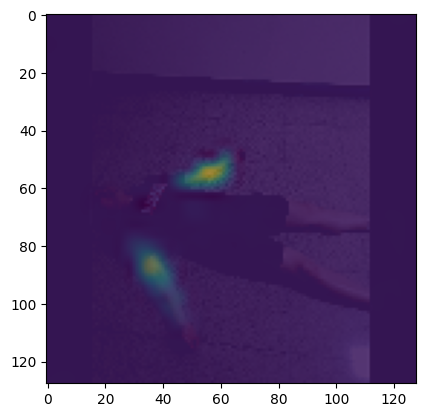

In [ ]:
plt.imshow(padded_img)
plt.imshow(heatmaps[:,:,6], alpha=0.5)
plt.imshow(pafs[:,:,16], alpha=0.5)
plt.show()